In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path=Path('C:/Users/NoobiWanKenobi/Documents/AI/Shaastra_AI/toxicity')

In [5]:
df = pd.read_csv(path/'train.csv',nrows=100000)

In [5]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [7]:
df.isnull().sum().sort_index()/len(df)

article_id                             0.00000
asian                                  0.80375
atheist                                0.80375
bisexual                               0.80375
black                                  0.80375
buddhist                               0.80375
christian                              0.80375
comment_text                           0.00000
created_date                           0.00000
disagree                               0.00000
female                                 0.80375
funny                                  0.00000
heterosexual                           0.80375
hindu                                  0.80375
homosexual_gay_or_lesbian              0.80375
id                                     0.00000
identity_annotator_count               0.00000
identity_attack                        0.00000
insult                                 0.00000
intellectual_or_learning_disability    0.80375
jewish                                 0.80375
latino       

In [8]:
len(df)

100000

In [9]:
data_lm = (TextList.from_df(df,cols='comment_text')
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=16))

In [10]:
data_lm.save('data_lm.pkl')

In [4]:
data_lm = load_data(path, 'data_lm.pkl', bs=16)

In [12]:
data_lm.show_batch()

idx,text
0,such an urgent design problem ; kudos to you for taking it on . xxmaj very impressive ! xxbos xxmaj is this something i 'll be able to install on my site ? xxmaj when will you be releasing it ? xxbos haha you guys are a bunch of losers . xxbos xxunk suck it . xxbos xxrep 4 f xxrep 15 u xxbos xxmaj the ranchers seem motivated by
1,xxunk ! \n 1 . xxmaj there is a history of musical chairs among principals ; my daughter had three different ones in as many years at xxmaj edison . xxmaj the same thing is occurring at xxmaj roosevelt and xxmaj south . xxmaj this is toxic ; it destroys cohesion . xxmaj is that what upper administration wants ? \n 2 . xxmaj ask parents xxup and
2,"just the last 12 months have made the front page of the xxup rg who were sited for allegedly failing to yield to a pedestrian ? xxbos xxmaj betty , maybe it 's time to stop driving . xxmaj we all ( hopefully ) will reach that milestone . i hope i quit while i 'm ahead , before ai plow into a crowd on a sidewalk or run over"
3,", xxmaj mrs. , xxmaj miss , xxmaj ms , or xxmaj dr. \n \n xxmaj perhaps because not everyone is gifted with proper manners . xxbos xxup kk : cowboy bush made it impossible to rein in prescription costs with his big deal with pharma companies . xxmaj also you can look to xxmaj washington xxmaj republicans for the the raid on citizens pockets to hold up xxmaj"
4,"who decry federal spending suddenly reverse course and cheer when the big bucks happen to come to town . xxmaj is it ironic ? xxmaj hypocritical ? or just a "" good "" decision ? xxmaj if there has to be a "" winner , "" why not xxmaj alaska ? xxmaj it all makes sense , on paper . xxmaj but it 's also a good reminder that the"


In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


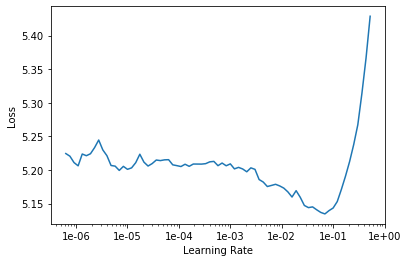

In [18]:
learn.recorder.plot(skip_end=15)

In [21]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.655085,4.492146,0.250244,13:11
1,4.412275,4.324421,0.266073,13:24


In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


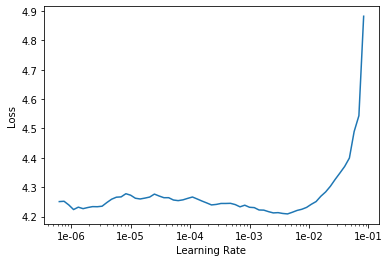

In [26]:
learn.recorder.plot(skip_end=15)

In [27]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.091853,4.149465,0.282457,15:00
1,4.131005,4.109639,0.290865,15:47
2,4.009571,4.046079,0.299151,15:49
3,3.765695,4.012027,0.305221,15:49
4,3.619239,4.023836,0.304914,15:52


In [28]:
learn.save('lm_fine_tuned')

In [29]:
learn.save_encoder('lm_fine_tuned_enc')

In [6]:
df['target']=df['target']*10

In [7]:
df['target']=df['target'].astype(int)

In [8]:
df['target']=df['target'].replace(to_replace=10,value=9)

In [9]:
df['target'].unique()

array([0, 8, 6, 4, 5, 9, 1, 2, 3, 7], dtype=int64)

In [10]:
df['target']=df['target']/5

In [11]:
df['target']=df['target'].astype(int)

In [16]:
data_clas = (TextList.from_df(df, cols='comment_text', vocab=data_lm.vocab)
             .split_by_rand_pct(0.1)
             .label_from_df(cols='target')
             .databunch(bs=4))

In [17]:
data_clas.save('data_clas.pkl')

In [4]:
data_clas = load_data(path, 'data_clas.pkl', bs=16)

In [20]:
data_clas.show_batch()

text,target
"xxbos xxmaj predatory patrol towing is n't a big subject , and there is no advocacy group that is paying any attention to it , but the xxmaj city of xxmaj portland has completely backed off of enforcing state law where the towing predators are operating on private property , and this is xxmaj commissioner xxmaj novick 's failure . xxmaj he 's in charge of towing . \n \n",0
"xxbos xxup r.i.p. xxmaj merle ... \n \n xxmaj we do n't smoke marijuana in xxmaj muskogee ; \n xxmaj we do n't take no trips on xxup lsd \n xxmaj we do n't burn no draft cards down on xxmaj main xxmaj street ; \n xxmaj we like livin ' right , and xxunk ' free . \n \n i 'm proud to be",0
"xxbos xxmaj maybe wishful thinking on your part , xxup rr : \n \n 04 / 24 / 11 : 19 year - old xxmaj ashley xxup n. xxmaj bashore ran down xxmaj hubert xxmaj tunuchuk and left him to die . xxmaj she was charged with “ failing to render assistance ” ( ! ) , got 18 months . xxmaj blondes may not have more fun ,",0
"xxbos xxmaj fine xxunk , but the substantive premises are only thinly veiled : \n \n xxmaj if you are against recent plans , like the xxmaj south xxmaj willamette xxmaj special xxmaj area xxmaj zone , _ you 're against planning . _ \n \n xxmaj if you express concerns that plans like xxup sw - xxup saz will degrade the livability of your immediate neighborhood ,",0
"xxbos 4 . xxmaj picking up on 5th and 6th is very difficult . xxmaj if you need to be picked up on one of those streets , please make sure you go to the appropriate side of the street ( the side we can actually drive on ) before calling for us . \n 5 . xxmaj lyft is just another xxmaj uber . xxmaj they do n't",0


In [5]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('lm_fine_tuned_enc');

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


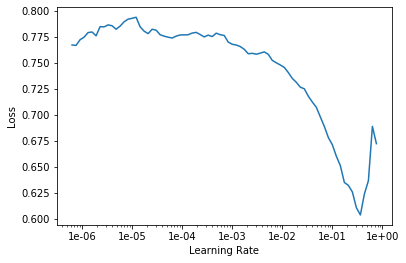

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.219972,0.198729,0.933800,05:27


In [25]:
learn.save('final1')

In [6]:
learn.load('final1');

In [7]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.146092,0.574526,0.946200,08:12


In [8]:
learn.save('final2')

In [6]:
learn.load('final2');

In [7]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.169214,0.399616,0.950800,12:28
